In [ ]:
!pip install mne

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets.sleep_physionet.age import fetch_data
from mne.time_frequency import psd_welch

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
import random

In [ ]:
black_list = [36, 52, 39, 68, 69, 78, 79]

#The first nights of subjects 36 and 52, and the second night of subject 13, were lost due to a failing cassette or laserdisk.
np.random.seed(0)
#subjects_train = np.random.randint(0, 82, size=30);
subjects_train = []
for i in range(82):
    if i in black_list:
      continue
    subjects_train.append(i)
random.shuffle(subjects_train)
subjects_train = subjects_train[:30]
#for i in range(83):
#subjects_train = np.array(range(15))

train_data = fetch_data(subjects=subjects_train, recording=[1])

raw_train = [mne.io.read_raw_edf(train_data[i][0], stim_channel='Event marker',
                                misc=['Temp rectal']) for i in range(len(train_data))]

annot_train = [mne.read_annotations(train_data[i][1]) for i in range(len(train_data))]

for i in range(len(train_data)):
    raw_train[i].set_annotations(annot_train[i], emit_warning=False)

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


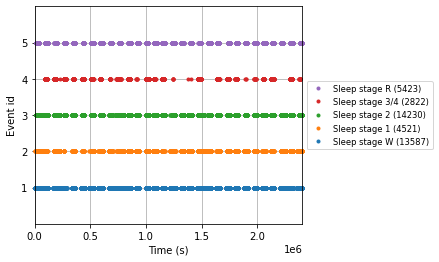

In [5]:
annotation_desc_2_event_id = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 4,
                              'Sleep stage 4': 4,
                              'Sleep stage R': 5}

# keep last 30-min wake events before sleep and first 30-min wake events after
# sleep and redefine annotations on raw data

for i in range(len(raw_train)):
    annot_train[i].crop(annot_train[i][1]['onset'] - 30 * 60,
                 annot_train[i][-2]['onset'] + 30 * 60)

for i in range(len(raw_train)):
    raw_train[i].set_annotations(annot_train[i], emit_warning=False)


mne.concatenate_raws(raw_train)

event, _ = mne.events_from_annotations(
raw_train[0], event_id=annotation_desc_2_event_id, chunk_duration=30.)


# create a new event_id that unifies stages 3 and 4
event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5}

# plot events
fig = mne.viz.plot_events(event, event_id=event_id, sfreq=raw_train[0].info['sfreq'], first_samp=event[0, 0])

# keep the color-code for further plotting
stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [6]:
tmax = 30. - 1. / raw_train[0].info['sfreq']  # tmax in included
#print(raw_train[0].info['sfreq'], raw_train[2].info['sfreq'])

epochs_train = mne.Epochs(raw=raw_train[0], events=event,
                          event_id=event_id, tmin=0., tmax=tmax, baseline=None)

Not setting metadata
40583 matching events found
No baseline correction applied
0 projection items activated


In [ ]:
black_list = [39, 68, 69, 78, 79]

#subjects_test = np.random.randint(0, 82, size=10)
#indexes = np.isin(subjects_test, subjects_train, invert=True)
#subjects_test = subjects_test[indexes]
#subjects_test = [2]
subjects_test = []
for i in range(82):
    if i in black_list or i in subjects_train:
      continue
    subjects_test.append(i)
random.shuffle(subjects_test)
subjects_test = subjects_test[:15]
#subjects_test = [16, 17, 18, 19, 20]

test_data = fetch_data(subjects=subjects_test, recording=[2], on_missing='raise')

raw_test = [mne.io.read_raw_edf(test_data[i][0], stim_channel='Event marker',
                                misc=['Temp rectal']) for i in range(len(test_data))]

annot_test = [mne.read_annotations(test_data[i][1]) for i in range(len(test_data))]

for i in range(len(test_data)):
    raw_test[i].set_annotations(annot_test[i], emit_warning=False)

for i in range(len(raw_test)):
    annot_test[i].crop(annot_test[i][1]['onset'] - 30 * 60,
                 annot_test[i][-2]['onset'] + 30 * 60)

for i in range(len(raw_test)):
    raw_test[i].set_annotations(annot_test[i], emit_warning=False)


mne.concatenate_raws(raw_test)

events_test, _ = mne.events_from_annotations(
raw_test[0], event_id=annotation_desc_2_event_id, chunk_duration=30.)

epochs_test = mne.Epochs(raw=raw_test[0], events=events_test,
                          event_id=event_id, tmin=0., tmax=tmax, baseline=None)

In [8]:
def eeg_power_band(epochs):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5]
        Transformed data.
    """
    # specific frequency bands
    FREQ_BANDS = {"delta": [0.5, 4.5],
                  "theta": [4.5, 8.5],
                  "alpha": [8.5, 11.5],
                  "sigma": [11.5, 15.5],
                  "beta": [15.5, 30]}

    psds, freqs = psd_welch(epochs, picks='eeg', fmin=0.5, fmax=30.)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

In [12]:
pipe = make_pipeline(FunctionTransformer(eeg_power_band, validate=False),
                     RandomForestClassifier(n_estimators=100, random_state=42, min_samples_leaf=50, max_depth=20))

# Train
y_train = epochs_train.events[:, 2]
pipe.fit(epochs_train, y_train)

# Test
y_pred = pipe.predict(epochs_test)

# Assess the results
y_test = epochs_test.events[:, 2]
acc = accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(acc))

Loading data for 40583 events and 3000 original time points ...
Effective window size : 2.560 (s)
Loading data for 19691 events and 3000 original time points ...
Effective window size : 2.560 (s)
Accuracy score: 0.7319079782641816
